Objectives
1. To provide legal literacy to the general public of India.
2. To provide basic legal support for filing cases to the common folks of India.
3. To provide source verification and resources for all the responses the system provides and enhance user trust.
4. To ensure consumer data is protected and masked.

In [1]:
# Create the folder structure for all four legal acts
!mkdir /content/divorce
!mkdir /content/copyright
!mkdir /content/consumer_protection
!mkdir /content/inheritance

In [2]:
# installing all necessary packages
%pip install transformers
%pip install datasets
%pip install huggingface_hub
%pip install torch

%pip install llama-index
%pip install llama-index-core
%pip install llama-index-embeddings-huggingface
%pip install llama-index-readers-file
%pip install transformers accelerate bitsandbytes
%pip install llama-index-readers-web
%pip install --upgrade --quiet llama-index-llms-nvidia llama-index-embeddings-nvidia llama-index-readers-file
%pip install "transformers[torch]" "huggingface_hub[inference]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Importing necessary packages
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import torch
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

from llama_index.core import Settings
from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.ingestion import IngestionPipeline

import logging
import sys
import os
import getpass
from IPython.display import Markdown, display
from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.core.settings import Settings
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine
from typing import List, Optional
from llama_index.llms.nvidia import NVIDIA
from llama_index.core.evaluation import FaithfulnessEvaluator, RelevancyEvaluator
import nest_asyncio

In [5]:
# del os.environ['NVIDIA_API_KEY']  ## delete key and reset
if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    print("Valid NVIDIA_API_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith(
        "nvapi-"
    ), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

NVAPI Key (starts with nvapi-): ··········


In [6]:
nest_asyncio.apply()

In [7]:
llm = NVIDIA(llm = "deepseek-ai/deepseek-r1")
evaluation_llm = NVIDIA()

In [8]:
# downloading the embedding model with the HuggingFace token
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# Global settings for the LLM and embedding model
Settings.llm = llm
Settings.embed_model = embed_model

## Overall architecture and intent recognition

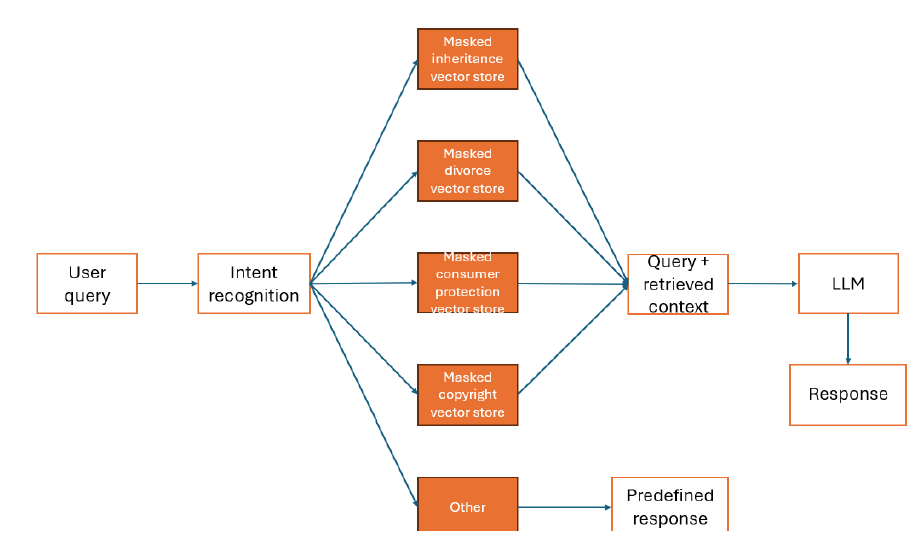

In [10]:
# intent and labels dict
intent_label_dict = {0: 'Divorce', 1: 'Consumer protection',2: 'Inheritance', 3: 'Copyright', 4: 'Other'}
# data and model save path
intent_data_path = '/content/intent_classification_train.xlsx'
model_path = "Sachin891/LegalRAG-intent-classification-distilbert"

In [11]:
# reading the training data for intent classification
intent_data = pd.read_excel(intent_data_path)
intent_data.head()

,Intent,Query
0,Divorce,How to get divorce?
1,Divorce,What to do to get alimony in divorce?
2,Divorce,What are the grounds for divorce?
3,Divorce,How long does the divorce process take?
4,Divorce,Can I file for divorce online?


In [12]:
# Showing all the intents and the number of records
intent_data['Intent'].value_counts()

,count
Intent,
Divorce,50
Inheritance,50
Copyright,50
Other,50
Consumer protection,49


In [13]:
# Function to calculate the metrics for intent classification
def compute_metrics(p):
    # Extract the predictions
    preds = p.predictions.argmax(-1)  # Get the index of the maximum logit value for each example
    labels = p.label_ids

    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute precision, recall, f1 for each class (weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [14]:
# Function to train the intent classification model using distilBERT and tokenizer
def intent_classification_train(path):
  # Load your dataset
  df = pd.read_excel(path)

  df.replace({'Divorce':0, 'Consumer protection':1, 'Inheritance':2, 'Copyright':3, 'Other':4}, inplace = True)

  X = df['Query'].copy()
  y = df['Intent'].copy()

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 30)

  train_df = pd.concat([X_train, y_train], axis = 1)
  test_df = pd.concat([X_test, y_test], axis = 1)

  # Convert to Hugging Face Dataset format
  raw_datasets = DatasetDict({
      "train": Dataset.from_pandas(train_df),
      "eval": Dataset.from_pandas(test_df)
  })

  # loading distilBERT and tokenizer for 5 class intent classification
  checkpoint = "distilbert-base-uncased"
  classifier = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)

  tokenized_datasets = raw_datasets.map(lambda dataset: tokenizer(dataset['Query'], truncation=True), batched=True)
  print(tokenized_datasets)

  tokenized_datasets = tokenized_datasets.remove_columns(["Query", "__index_level_0__"])
  tokenized_datasets = tokenized_datasets.rename_column("Intent", "labels")
  print(tokenized_datasets)

  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Training args
  training_args = TrainingArguments("test-trainer", num_train_epochs=5, evaluation_strategy="epoch",
                                    weight_decay=5e-4, save_strategy="no", report_to="none")

  # Define trainer
  trainer = Trainer(
      classifier,
      training_args,
      train_dataset=tokenized_datasets["train"],
      eval_dataset=tokenized_datasets["eval"],
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics
  )

  # Fine-tuning of distilBERT
  trainer.train()

  # Evaluate the model
  results = trainer.evaluate()

  # Print the evaluation metrics
  print("On evaluation dataset:")
  print(f"Accuracy: {results['eval_accuracy']:.4f}")
  print(f"Precision: {results['eval_precision']:.4f}")
  print(f"Recall: {results['eval_recall']:.4f}")
  print(f"F1-score: {results['eval_f1']:.4f}")

  return trainer, tokenizer

In [15]:
# typing yes trains the intent classification model, typing no uses the already trained intent classification model
train_or_not = input("Do you want to retrain/fine-tune the intent classifier model? ")

Do you want to retrain/fine-tune the intent classifier model? no


In [16]:
# logging in to huggingface to load the saved intent classification model
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `llama2` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `llama2`


In [ ]:
if train_or_not == 'yes':
  # train the model
  trainer, tokenizer = intent_classification_train(intent_data_path)
  # Save the model and tokenizer locally
  trainer.save_model('content/intent_classifier')
  tokenizer.save_pretrained('content/intent_tokenizer')

  # Load the saved model and tokenizer
  model = AutoModelForSequenceClassification.from_pretrained('content/intent_classifier')

  # Push to Hugging Face Hub
  model.push_to_hub(model_path)

<ipython-input-16-051ab6fba71c>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Divorce':0, 'Consumer protection':1, 'Inheritance':2, 'Copyright':3, 'Other':4}, inplace = True)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Query', 'Intent', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 199
    })
    eval: Dataset({
        features: ['Query', 'Intent', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 199
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-051ab6fba71c>:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.913400,0.940000,0.948485,0.940000,0.939546
2,No log,0.218048,0.980000,0.981818,0.980000,0.979950
3,No log,0.095519,0.980000,0.981818,0.980000,0.979950
4,No log,0.083307,0.960000,0.963636,0.960000,0.959900
5,No log,0.075947,0.960000,0.963636,0.960000,0.959900


On evaluation dataset:
Accuracy: 0.9600
Precision: 0.9636
Recall: 0.9600
F1-score: 0.9599


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [17]:
# load the saved model and return the model and tokenizer
def load_model(model_path):

    # load the tokenizer
    checkpoint = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # Load the saved model from huggingface
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=5)

    return model, tokenizer

In [18]:
# Function to make inferences using the intent classification model
def intent_inference(user_query, model, tokenizer, intent_label_dict):

    # creating the tokenizer and pipeline for input conversion to tokens and score from the model
    inputs = tokenizer(user_query, return_tensors="pt", padding='max_length', truncation=True, max_length=128)

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

    results = pipe(user_query)[0]
    max_score = 0
    for i, result in enumerate(results):
      if result['score'] > max_score:
        max_score = result['score']
        label = i

    return intent_label_dict[label]

In [19]:
# loading the trained model and tokenizer
model, tokenizer = load_model(model_path)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [20]:
query = "How can I protect my rights as a consumer?"
intent_inference(query, model, tokenizer, intent_label_dict)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


'Consumer protection'

In [21]:
query = "How to get divorce?"
intent_inference(query, model, tokenizer, intent_label_dict)

Device set to use cuda:0


'Divorce'

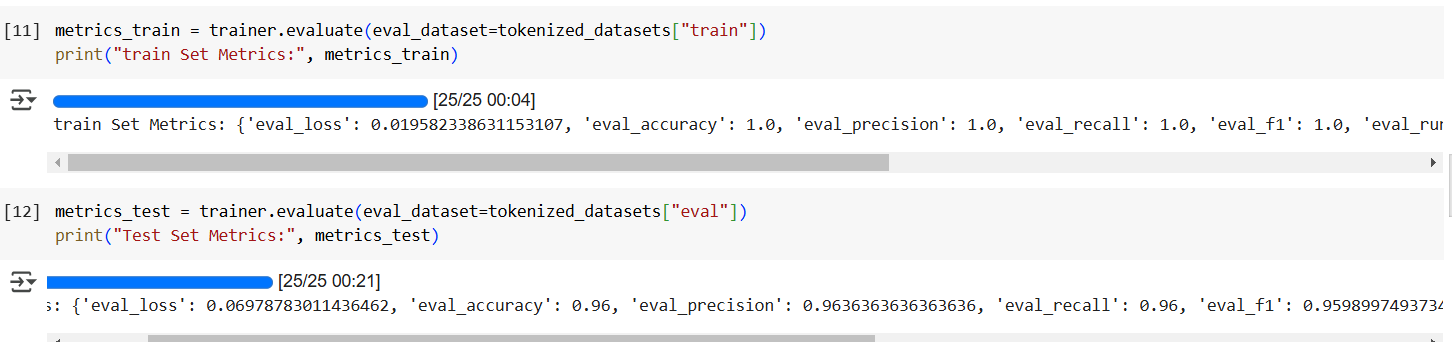

## Chunking, embedding and storing data in a vector database

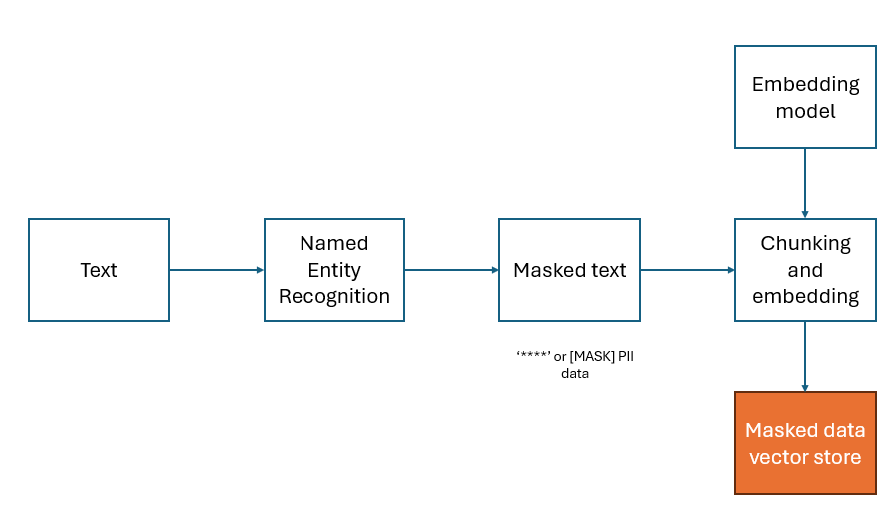

In [22]:
# Loading the document for all 4 legal acts
doc_loader1 = SimpleDirectoryReader("/content/copyright")
documents1 = doc_loader1.load_data()

doc_loader2 = SimpleDirectoryReader("/content/divorce")
documents2 = doc_loader2.load_data()

doc_loader3 = SimpleDirectoryReader("/content/consumer_protection")
documents3 = doc_loader3.load_data()

doc_loader4 = SimpleDirectoryReader("/content/inheritance")
documents4 = doc_loader4.load_data()

# Creating a SentenceSplitter with chunk size, chunk overlap
text_splitter = SentenceSplitter(
  separator=" ",
  chunk_size=80,
  chunk_overlap=20

)

pipeline = IngestionPipeline(
    transformations=[
        text_splitter,
        embed_model
    ])

# Chunking the document
nodes1 = pipeline.run(documents=documents1)
print("Number of nodes for copyright:",len(nodes1))

nodes2 = pipeline.run(documents=documents2)
print("Number of nodes for divorce:",len(nodes2))

nodes3 = pipeline.run(documents=documents3)
print("Number of nodes for consumer protection:",len(nodes3))

nodes4 = pipeline.run(documents=documents4)
print("Number of nodes for inheritance:",len(nodes4))

# Creating an index and storing in an in-memory vectorstore
index_copyright = VectorStoreIndex(nodes1)
index_divorce = VectorStoreIndex(nodes2)
index_consumer_protection = VectorStoreIndex(nodes3)
index_inheritance = VectorStoreIndex(nodes4)

Number of nodes for copyright: 18
Number of nodes for divorce: 72
Number of nodes for consumer protection: 16
Number of nodes for inheritance: 47


## HyDE

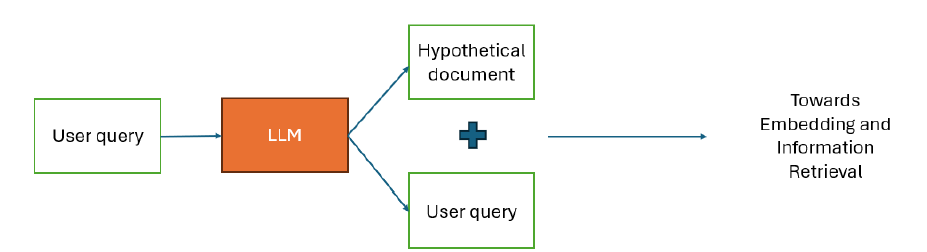

In [23]:
# Function to generate HyDE document and perform retrieval and response generation from the LLM
def rag(user_query, index):

  # simple retrieval that uses cosine similarity and gets top 5 most similar records
  query_engine = index.as_query_engine(similarity_top_k = 5)
  # Creating HyDE retrieval
  hyde = HyDEQueryTransform(include_original=True)
  hyde_query_engine = TransformQueryEngine(query_engine, hyde)

  # generating HyDE document
  query_bundle = hyde(user_query)
  hyde_doc = query_bundle.embedding_strs[0]

  # using HyDE retrieval to get context and use the context to generate a response from the LLM
  response = hyde_query_engine.query(user_query)

  return response, response.source_nodes, hyde_doc

In [24]:
# Function that uses intent to move the query to the relevant vector store
def legalRAG(intent, user_query, indexes):
  if intent == 'Copyright':
    response, source_nodes, hyde_doc = rag(user_query, indexes[0])

  elif intent == 'Divorce':
    response, source_nodes, hyde_doc = rag(user_query, indexes[1])

  elif intent == 'Consumer protection':
    response, source_nodes, hyde_doc = rag(user_query, indexes[2])

  elif intent == 'Inheritance':
    response, source_nodes, hyde_doc = rag(user_query, indexes[3])

  # if the user intent is unrelated to the 4 acts then give a generic response
  else:
    response = "Please ask questions related to Divorce act, inheritance act, consumer protection act, or copyright act"
    hyde_doc = None
    source_nodes = None

  return response, source_nodes, hyde_doc

In [25]:
indexes = [index_copyright, index_divorce, index_consumer_protection, index_inheritance]

In [26]:
user_query = "How can I get alimony after divorce?"
intent = intent_inference(user_query, model, tokenizer, intent_label_dict)
print("Intent of the query:", intent)
response, source_nodes, hyde_doc = legalRAG(intent, user_query, indexes)
print("Response:")
response.response

Device set to use cuda:0


Intent of the query: Divorce
Response:


'In a divorce after a decade of marriage, the spouse is entitled to life-long alimony. The court will consider several factors, including the age of the person receiving alimony, their economic condition, and the health of the spouse. The court will also take into account the earning potential of the husband, his ability to regenerate his fortune, and his liabilities.'

In [27]:
print("HyDE response:")
print(hyde_doc)

HyDE response:
When it comes to getting alimony after a divorce, there are several key factors to consider. First and foremost, alimony is typically awarded to the spouse who is in a more financially disadvantaged position, often referred to as the "dependent spouse." This can include individuals who have given up their career to care for children, those who have been out of the workforce for an extended period, or those who have limited earning capacity.

To be eligible for alimony, the dependent spouse must demonstrate a need for financial support, which can be established through documentation of their income, expenses, and assets. The court will also consider the income and earning capacity of the other spouse, known as the "supporting spouse," to determine if they have the ability to provide financial support.

In determining the amount of alimony, the court will consider several factors, including the length of the marriage, the age and health of both spouses, the income and earn

In [28]:
for node in source_nodes:
  print(node.text)
  print("---------------")

Divorce after a decade of marriage entitles the spouse to life-long alimony. The other important factors that need to be considered are given here:
* Age of the person who is entitled to receive the alimony
* The economic condition or the earnings potential of the person who is entitled to pay alimony
* The health of spouse,
---------------
Divorce after a decade of marriage entitles the spouse to life-long alimony.
---------------
While deciding that the alimony is to be paid, the courts will take into account the earning potential of the husband, his ability to regenerate his fortune (the property is given to the wife) and his liabilities. Note: In some cases,
---------------
This will include, spouse, dependent children and even indigent parents.
Computing amount of alimony
The alimony claim of either spouse (though, in the vast majority of cases, it is the wife) depends on whether the husband has sufficient means.
---------------
Note: In some cases, the court can make an order to 

In [29]:
user_query = "How to file a complaint for damaged goods?"
intent = intent_inference(user_query, model, tokenizer, intent_label_dict)
print("Intent of the query:", intent)
response, source_nodes, hyde_doc = legalRAG(intent, user_query, indexes)
print("Response:")
response.response

Device set to use cuda:0


Intent of the query: Consumer protection
Response:


'A consumer complaint relating to a good must be filed in writing with a District Forum by the consumer along with the fee.'

In [30]:
print("HyDE response:")
print(hyde_doc)

HyDE response:
Filing a complaint for damaged goods can be a straightforward process if you follow the right steps. First, it's essential to document the damage by taking clear photos or videos of the affected area and any visible damage. This visual evidence will help support your claim and provide a clear understanding of the issue. Next, contact the seller or manufacturer's customer service department to report the damage and request a resolution. Be prepared to provide your order number, product details, and a detailed description of the damage.

If you purchased the item online, you may also need to contact the online retailer's customer service department. They will likely have a specific process for handling damaged goods and may require you to return the item before issuing a refund or replacement. Be sure to ask about their return policy and any specific requirements for returning damaged goods.

In addition to contacting the seller or manufacturer, you may also want to file a

In [31]:
for node in source_nodes:
  print(node.text)
  print("---------------")

Procedure to File Consumer Case
Any consumer complaint relating to a good or service must be filed in writing with a District Forum by the consumer along with the fee. On receipt of a complaint, the District Forum may reject or approve the complaint, usually within 21 days from the date of complaint.
---------------
How and When to Complain
Under the Consumer Protection Act, the customer can raise a complaint in writing if:
* Adoption of any unfair trade practise or a restrictive trade practice by any trader or service provider;
* The goods bought by him or agreed to be bought by him suffer from one or more defects;
---------------
as the case may be, has charged for the goods or for the services mentioned in the complaint, a price in excess of the price:
   * Fixed by or under any law for the time being in force;
   * Displayed on the goods or any package containing such goods;
---------------
On the other hand, a copy of the complaint will reach the opposite party for the approval to

In [32]:
user_query = "Who is a legal heir?"
intent = intent_inference(user_query, model, tokenizer, intent_label_dict)
print("Intent of the query:", intent)
response, source_nodes, hyde_doc = legalRAG(intent, user_query, indexes)
print("Response:")
response.response

Device set to use cuda:0


Intent of the query: Inheritance
Response:


'An individual who takes the place of the property of his/her ancestor, either by law or by a will.'

In [33]:
print("HyDE response:")
print(hyde_doc)

HyDE response:
Here is a passage that answers the question:

A legal heir is an individual who inherits property, assets, or rights from a deceased person, typically in accordance with the laws of the country or jurisdiction. In general, a legal heir is a person who has a legal claim to the property or assets of the deceased, usually due to a blood relationship or a legal agreement. In most cases, legal heirs are immediate family members, such as spouses, children, parents, siblings, or grandparents. However, the definition of a legal heir can vary depending on the specific laws and customs of a particular region or culture. For example, in some countries, a legal heir may also include distant relatives, such as aunts, uncles, nieces, or nephews, or even individuals who have been designated as heirs through a will or trust. In addition, legal heirs may also include individuals who have been appointed as executors or administrators of the deceased person's estate, responsible for managi

In [34]:
for node in source_nodes:
  print(node.text)
  print("---------------")

Therefore a legal heir is an individual who takes the place of the property of his/her ancestor, either by law or by a will.
Importance of heir
It is essential to identify a legal heir for every person owning property; they are the successors for property claims and insurance coverage.
---------------
Legal heir in India?
According to India laws, a person who is determined to succeed to the estate of an ancestor who has died without making a will or mentioning a legal heir.
---------------
Legal heir under Hindu law
Under the Hindu Succession (Amendment) Act, 2005, the following can be the legal heir of a person: Class I
* Wife (Widow)
* Mother
* Son
* Daughter
* Deceased son’s daughter
* Deceased daughter’s
---------------
legal heirs of a Parsi person are:
* Father
* Mother
* Full brother
* Full sister
* Paternal grandparents
* Maternal grandparents
* Children of maternal grandparents and their lineal descendants
* Children of paternal grandparents and their lineal descendants
* Pare

In [35]:
user_query = "what is copyright infringement?"
intent = intent_inference(user_query, model, tokenizer, intent_label_dict)
print("Intent of the query:", intent)
response, source_nodes, hyde_doc = legalRAG(intent, user_query, indexes)
print("Response:")
response.response

Device set to use cuda:0


Intent of the query: Copyright
Response:


'A criminal offense punishable under Section 63 of the Copyright Act, with a minimum punishment of imprisonment for six months and a minimum fine of Rs.50,000/-.'

In [36]:
print("HyDE response:")
print(hyde_doc)

HyDE response:
Here is a passage that answers the question:

Copyright infringement is the unauthorized use, reproduction, or distribution of someone else's original work, such as a book, song, movie, or piece of art, without their permission or consent. This can include copying or downloading copyrighted material, such as music, images, or videos, without obtaining the necessary licenses or permissions. Copyright infringement can also involve distributing or sharing copyrighted material, such as sharing a pirated copy of a movie or music album, or uploading copyrighted content to a website or social media platform without permission.

In the United States, copyright law is governed by the Copyright Act of 1976, which grants creators of original works the exclusive right to reproduce, distribute, and display their work. This means that copyright holders have the right to control how their work is used, and to prevent others from using it without their permission. If someone infringes o

In [37]:
for node in source_nodes:
  print(node.text)
  print("---------------")

Remedy for copyright infringement
Copyright infringement of any work is a criminal offense punishable under Section 63 of the Copyright Act. The minimum punishment for infringement of a copyright is imprisonment for six months with a minimum fine of Rs.50,000/-.
---------------
In this article we look at the basics of copyright registration in India:
Copyright
Copyright is a right to ownership and enjoyment given by the law to creators of literary, dramatic, musical, artistic works and producers of cinematograph films and sound recordings.
---------------
It is a bundle of rights comprising of rights to reproduction, communication to the public, adaptation and translation of the work. Copyright ensures certain minimum safeguards of the rights of ownership and enjoyment of the authors over their creations, thereby protecting and rewarding creativity.
What can be copyrighted?
---------------
Also, in case a copyright infringement has happened or happening or likely to happen, any police 

In [38]:
user_query = "Where to go for vacation?"
intent = intent_inference(user_query, model, tokenizer, intent_label_dict)
print("Intent of the query:", intent)
response, source_nodes, hyde_doc = legalRAG(intent, user_query, indexes)
print("Response:")
print(response)
print("HyDE response:")
print(hyde_doc)

Device set to use cuda:0


Intent of the query: Other
Response:
Please ask questions related to Divorce act, inheritance act, consumer protection act, or copyright act
HyDE response:
None


In [39]:
source_nodes